In [1]:
import zombie_imp
import csv
import serial
import time 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import pywt

In [2]:
# Initialize the Serial port
ser = serial.Serial('COM3', 115200)  # Change the port and baud rate according to transmitter

# create the CSV file
with open('sensor_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cell 1', 'Cell 2', 'Cell 3'])  

    # read the data from port and store in CSV file
    try:
        while True:
            data = ser.readline().decode('utf-8', errors='ignore').strip()  # read data from port
            if data:
                values = data.split(' ')  # split with space
                if len(values) == 3:  # make sure there are three values
                    writer.writerow([int(val) for val in values])  # store the data
    except KeyboardInterrupt:  # stop iteration by Ctrl+C
        pass

In [3]:
# read the csv file
# df = pd.read_csv('left_to_right.csv')

# get the data of each solar cell
solar_cell_1 = df['Cell 1']
solar_cell_2 = df['Cell 2']
solar_cell_3 = df['Cell 3']

# apply DWT for the current value of each solar cell
coeffs_1 = pywt.wavedec(solar_cell_1, 'haar', level=5) #coeffs_1[0] contains the first-level approximation coefficient of solar_cell_1, coeffs_1[1] contains the first-level detail coefficient of solar_cell_1
coeffs_2 = pywt.wavedec(solar_cell_2, 'haar', level=6)
coeffs_3 = pywt.wavedec(solar_cell_3, 'haar', level=5)

print("Coefficients for solar_cell_1:", coeffs_1)
print("Coefficients for solar_cell_2:", coeffs_2)
print("Coefficients for solar_cell_3:", coeffs_3)

Coefficients for solar_cell_1: [array([1181.39865467, 1167.25651904, 1164.25131522, 1164.42809192,
       1165.84230548, 1166.54941226, 1165.84230548, 1163.36743175,
       1163.54420844, 1165.1351987 , 1166.72618896, 1165.84230548,
       1163.19065505, 1164.25131522, 1163.54420844, 1165.1351987 ,
       1164.25131522, 1161.59966479, 1162.83710166, 1164.25131522,
       1166.54941226, 1166.72618896, 1164.25131522, 1165.1351987 ,
       1169.20106269, 1172.91337329, 1172.20626651, 1169.55461608,
       1170.43849956, 1172.5598199 , 1176.2721305 , 1174.85791694,
       1170.79205295, 1172.38304321, 1174.32758686, 1176.62568389,
       1174.85791694, 1168.8475093 , 1168.31717922, 1167.07974235,
       1164.78164531, 1155.58925715, 1137.91158762, 1117.40549097,
       1093.01030702, 1056.2407544 ,  964.31687284,  909.16254391,
        881.40860275,  860.90250609,  835.97699206,  788.95439111,
        759.96301308,  747.05831432,  746.17443085,  751.47773171,
        772.33738175,  778.701

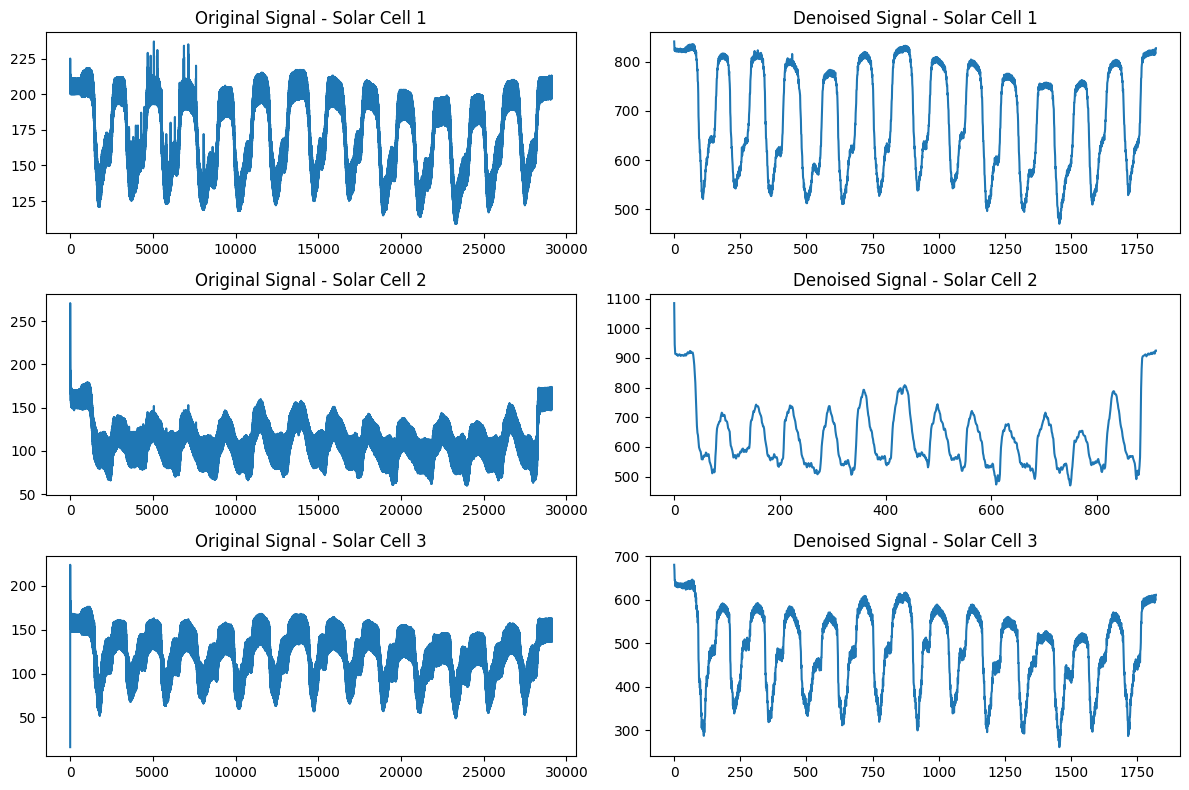

In [4]:
approx_coeff_1 = coeffs_1[0]
detail_coeff_1 = coeffs_1[1]
approx_coeff_2 = coeffs_2[0]
detail_coeff_2 = coeffs_2[1]
approx_coeff_3 = coeffs_3[0]
detail_coeff_3 = coeffs_3[1]

# should be changed based on reality
threshold = 0.4

# apply a threshold on detail coeffcient
detail_coeff_thresh_1 = pywt.threshold(detail_coeff_1, threshold, mode='soft')
detail_coeff_thresh_2 = pywt.threshold(detail_coeff_2, threshold, mode='soft')
detail_coeff_thresh_3 = pywt.threshold(detail_coeff_3, threshold, mode='soft')

# reconstruct the signal
coeffs_denoised_1 = [approx_coeff_1, detail_coeff_thresh_1]
solar_cell_denoised_1 = pywt.waverec(coeffs_denoised_1, 'haar')
coeffs_denoised_2 = [approx_coeff_2, detail_coeff_thresh_2]
solar_cell_denoised_2 = pywt.waverec(coeffs_denoised_2, 'haar')
coeffs_denoised_3 = [approx_coeff_3, detail_coeff_thresh_3]
solar_cell_denoised_3 = pywt.waverec(coeffs_denoised_3, 'haar')


# plot the comparison of single before and after denoising
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(solar_cell_1)
plt.title('Original Signal - Solar Cell 1')

plt.subplot(3, 2, 2)
plt.plot(solar_cell_denoised_1)
plt.title('Denoised Signal - Solar Cell 1')

plt.subplot(3, 2, 3)
plt.plot(solar_cell_2)
plt.title('Original Signal - Solar Cell 2')

plt.subplot(3, 2, 4)
plt.plot(solar_cell_denoised_2)
plt.title('Denoised Signal - Solar Cell 2')

plt.subplot(3, 2, 5)
plt.plot(solar_cell_3)
plt.title('Original Signal - Solar Cell 3')

plt.subplot(3, 2, 6)
plt.plot(solar_cell_denoised_3)
plt.title('Denoised Signal - Solar Cell 3')

plt.tight_layout()
plt.show()